In [1]:
%matplotlib inline
from diffusion_maps import diff_map_solver
from dataloader import *
from plotter import *
from itertools import combinations
import numpy as np

In [2]:
hyper_params = {
               #Higher dimension size
               'dim_H' : 9,
               #Density of the simulation (dimensionless)
               'density' : 0.003,
               #Num of particles in cluster
               'num_particles' : 3,
               #Number of configurations to be used (5001 is total)
               'num_data' : 1000
               }
            
#initialize solver using the defined above  
diff_map_solver = diff_map_solver(hyper_params)
diff_map_solver.num_steps = diff_map_solver.num_data


[[-3.8669e-01  3.7009e-01  3.9520e-01 ...  6.1723e-01 -1.6337e-01
   1.6516e-01]
 [ 6.4740e-01 -7.8666e-01 -5.9726e-02 ... -1.6122e+00  2.5978e+00
   2.4166e+00]
 [ 6.4952e-01 -7.6057e-01 -4.0808e-01 ...  1.9642e+00  4.7524e+00
  -3.3539e+00]
 ...
 [-1.8022e-01 -3.3991e-01 -2.2955e-01 ...  5.9459e-02  6.2990e-01
  -7.9016e-01]
 [-4.3601e-01 -2.6203e-03 -4.0937e-01 ...  2.2058e-01 -6.3847e-01
   2.2443e-01]
 [-5.3492e-01 -2.7378e-03  3.6752e-01 ...  5.0878e-01 -4.0266e-01
   1.1442e-01]]


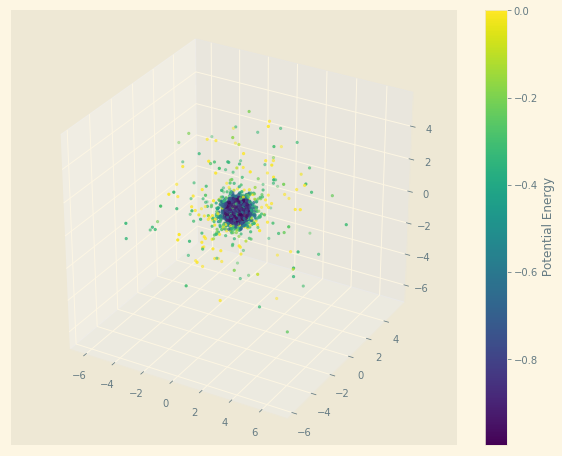

In [3]:
#load dataset
coordinates = load_features("../data/features.txt",3)
potentials = load_labels("../data/labels.txt", 1)

coordinates = coordinates[:hyper_params['num_data']]
potentials = potentials[:hyper_params['num_data']]

print(coordinates)
x = []
y = []
z = []
c = []
for i in range(len(coordinates)):
    for j in range(0, len(coordinates[i]), 3):
        x.append(coordinates[i][j+0])
        y.append(coordinates[i][j+1])  
        z.append(coordinates[i][j+2])
        c.append(potentials[i])
plt.style.use('Solarize_Light2')

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
a = ax.scatter(x, y, z, s=5, c=np.array(c).flatten())
fig.colorbar(a, label=' Potential Energy')
plt.show()

# STEP 1: Calculate R and G 

$$
   R =
  \left[ {\begin{array}{cc}
   0 & r_{12} & r_{13} \\
   r_{21} & 0 & r_{23} \\
   r_{31} & r_{32} &0 \\
  \end{array} } \right] \\ \\
$$

Where $r_{ij}$ is distance between particle i and j and G is basically turning R into a binary array (0 and 1) based on cutoff distance.


In [4]:
R, G = diff_map_solver.calculate_R_G(coordinates)

# STEP 2: Execute ISO rank algorithm to get best representing alignments(will add explanation soon.. )

In [5]:
R_, G_ = diff_map_solver.isorank(coordinates, R, G)

# STEP 3: Calc distance matrix

The distance matrix is the result of non-linear kernel making it non-linear version of PCA

$$d = \sum_{i} |R^*_i*G^*_i - R_i G_i| = 1$$



In [6]:
d = diff_map_solver.compute_d(R, G, R_, G_)

In [7]:
#compute A matrix (A_ij = e^(d_ij^2 / 2*sigma))
A = diff_map_solver.compute_A(d)

In [8]:
#compute D matrix
D = diff_map_solver.compute_D(A)

In [9]:
#compute M matrix = D' * A
M = diff_map_solver.compute_M(D, A)

/anaconda2/lib/python2.7/site-packages/matplotlib/transforms.py:841: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.array(args, dtype=float).reshape(2, 2)
/anaconda2/lib/python2.7/site-packages/numpy/core/numeric.py:553: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


explained variance saved in exp_cuml_var.png!


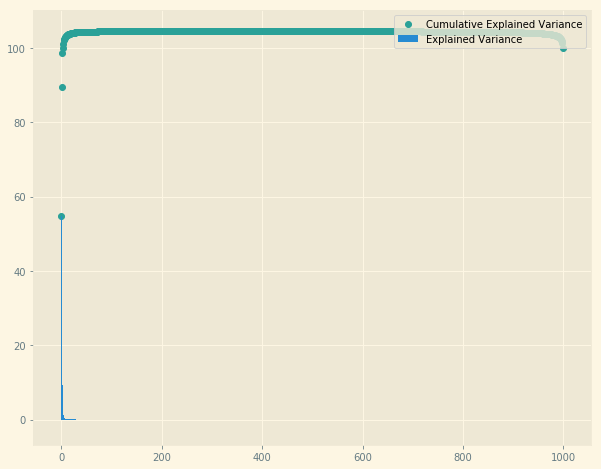

In [10]:
eig_vals, eig_vecs = diff_map_solver.generate_eigenspace(M)
#sort the eigen space in descending order
#calculate and plot the variance of each eigenvalue
diff_map_solver.plot_explained_variance(eig_vals);

In [31]:
num_particles = hyper_params['num_particles']
num_data = hyper_params['num_data']

#extract some information from the feature space 
side_length_space = [] #side lengths between each particles
perimeter = [] #side lengths between each particles
n_bonds = np.zeros(num_data) #number of bonds in the structure
cut_off_distance = 1.5 #sigma  
for i in range(num_data):
    side_length_space.append([])
    particles = np.reshape(coordinates[i], [num_particles, 3])
    perms = combinations(particles, 2) 
    for perm in perms:
        side_length_space[i].append(np.linalg.norm(perm[0] - perm[1]))   
    perimeter.append(np.sum(side_length_space[i]))
    for j in range(len(side_length_space[i])):
        if side_length_space[i][j] < cut_off_distance:
            n_bonds[i] += 1 

We can see that the first three eigenvalues basically explain 100% of the variance! Proving dimensionality can be reduced to 2. We need to ignore the first eigenvector as it represents transition to itself (making it trivial). Now Lets see how the reduced space looks like

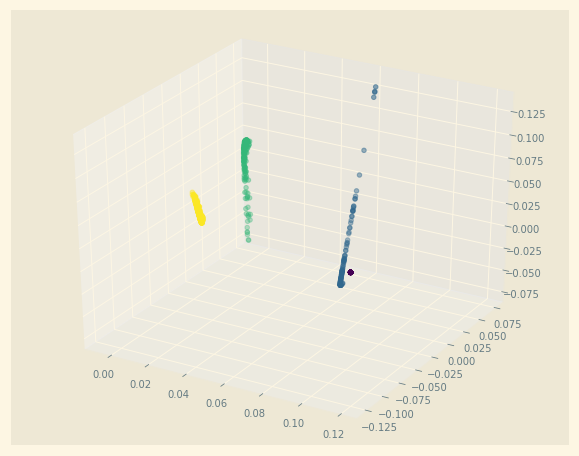

In [32]:
diff_map_solver.plot_new_space_3d(eig_vals, eig_vecs, np.reshape(n_bonds[:hyper_params['num_data']], hyper_params['num_data']))


([(-0.003699508343457186+0j),
  (0.062493329269351014+0j),
  (0.057395928697310084+0j),
  (-0.003754386329503617+0j),
  (0.007464720094641899+0j),
  (-0.004357132589902746+0j),
  (0.009198619652580417+0j),
  (-0.003761955582725113+0j),
  (-0.004513979759781144+0j),
  (-0.003462951167279602+0j),
  (-0.003952854042295745+0j),
  (-0.00362739768673951+0j),
  (-0.0037872838330966214+0j),
  (0.007577536344167246+0j),
  (-0.0035636518447739827+0j),
  (-0.0045360043789304545+0j),
  (-0.004034605370507112+0j),
  (-0.004133594667985914+0j),
  (-0.004360275404383842+0j),
  (-0.0038268503934170213+0j),
  (-0.0035755466595971818+0j),
  (-0.004414569092362761+0j),
  (-0.003739314555149927+0j),
  (-0.003974895518000797+0j),
  (-0.0035094557861914868+0j),
  (-0.003983358562597007+0j),
  (0.1192018751894765+0j),
  (0.1192018751894765+0j),
  (0.0598338148546929+0j),
  (0.1192018751894765+0j),
  (0.05722328348716726+0j),
  (-0.003931006865705838+0j),
  (-0.0036751668878431025+0j),
  (0.007477990389991721

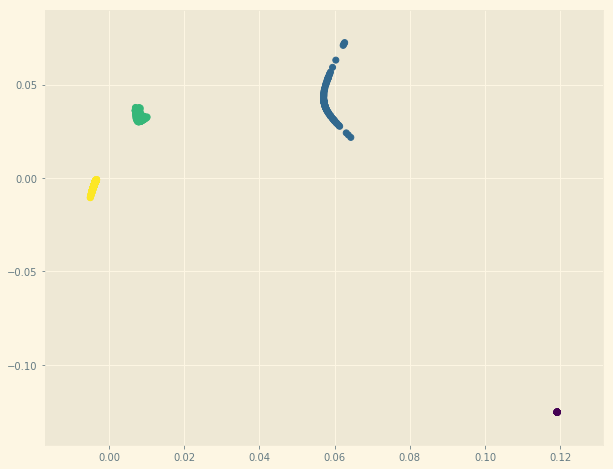

In [33]:
diff_map_solver.plot_new_space_2d(eig_vals, eig_vecs, np.reshape(n_bonds[:hyper_params['num_data']], hyper_params['num_data']))


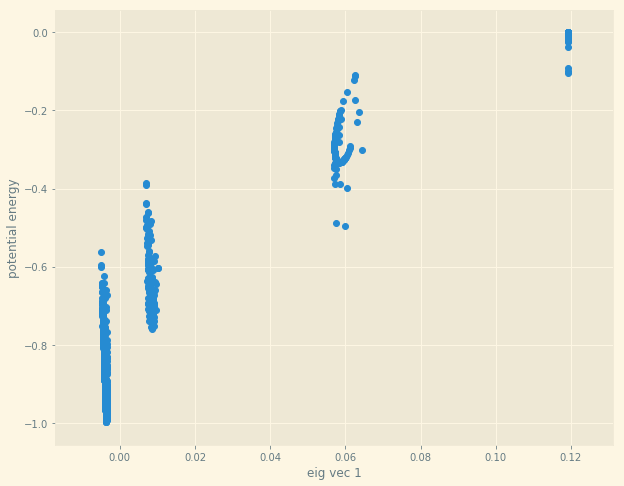

In [34]:
diff_map_solver.map_potential_energy(eig_vals, eig_vecs, np.reshape(potentials[:hyper_params['num_data']], hyper_params['num_data']))


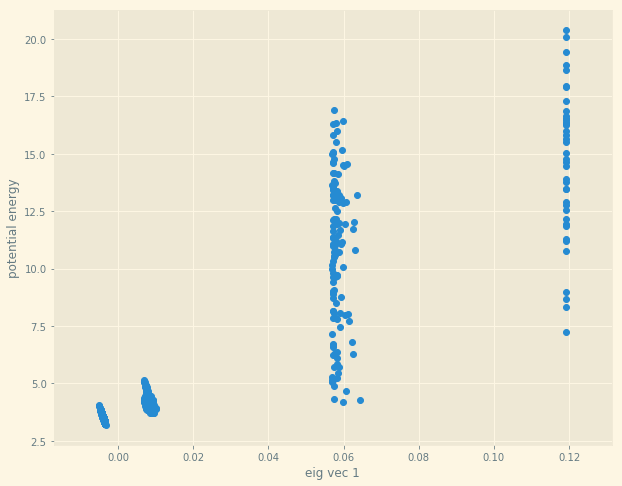

In [35]:
diff_map_solver.map_potential_energy(eig_vals, eig_vecs, np.reshape(perimeter[:hyper_params['num_data']], hyper_params['num_data']))


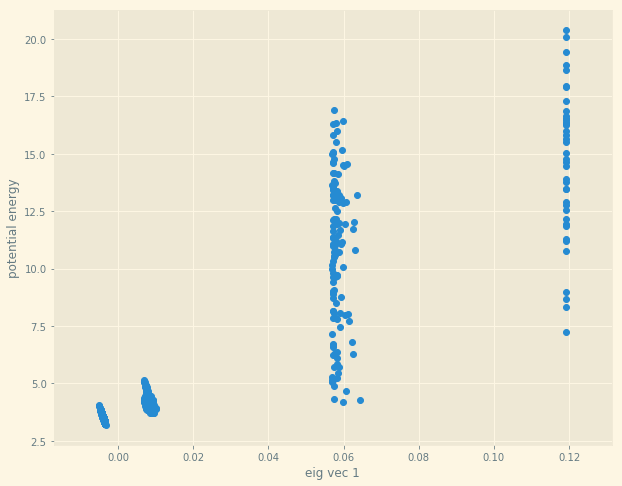

In [36]:
diff_map_solver.map_potential_energy(eig_vals, eig_vecs, np.reshape(perimeter[:hyper_params['num_data']], hyper_params['num_data']))


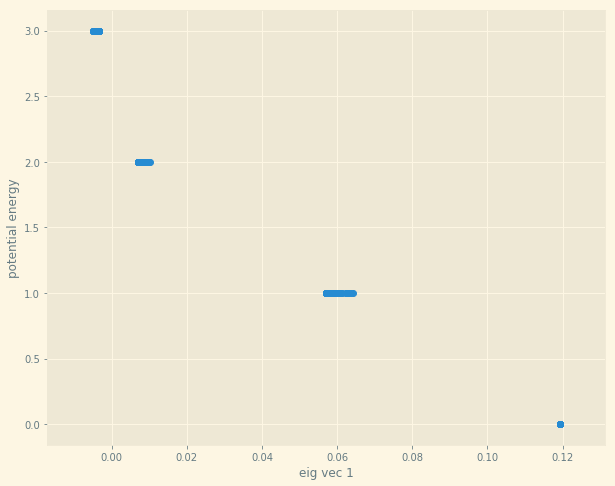

In [37]:
diff_map_solver.map_potential_energy(eig_vals, eig_vecs, np.reshape(n_bonds[:hyper_params['num_data']], hyper_params['num_data']))

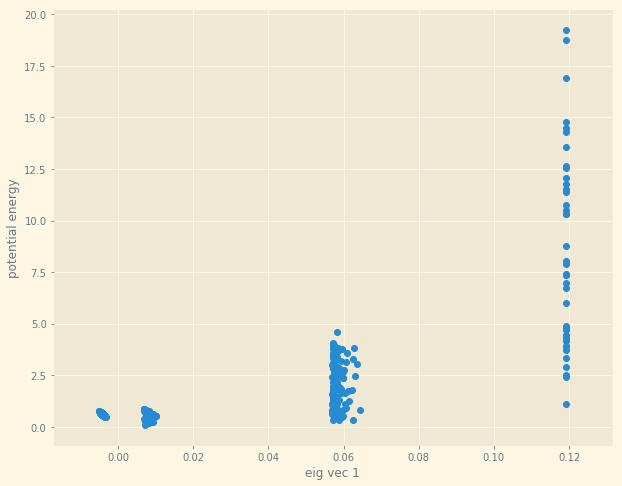

In [38]:
area = []
for i in range(len(coordinates)):
    points = np.reshape(coordinates[i], [3, 3])
    r1 = points[1] - points[0]
    r2 = points[2] - points[0]
    area.append(np.linalg.norm(np.cross(r1, r2))*0.5)

diff_map_solver.map_potential_energy(eig_vals, eig_vecs, np.reshape(area[:hyper_params['num_data']], hyper_params['num_data']))

In [96]:
def get_principle_components(eigvals, eigvecs, n):
    eigvals_sorted = sorted(eigvals, reverse=True)
    principle_components = []
    for i in range(n):
        idx = diff_map_solver.index(eigvals, eigvals_sorted[i])
        principle_components.append(idx)
    return principle_components
print(get_principle_components(eig_vals, eig_vecs, 3))

[0, 1, 2]


In [89]:
def plot_new_space_3d( eigvals, eigvecs, potentials):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')  
    c = []
    temp = []
    temp = sorted(temp,reverse=True)
    for i in range(len(eigvals)):
            temp.append(eigvals[i])
    idx1 = diff_map_solver.index(eigvals, temp[1])
    idx2 = diff_map_solver.index(eigvals, temp[2])
    idx3 = diff_map_solver.index(eigvals, temp[3])
    x_plt = []
    y_plt = []
    z_plt = []
    for i in range(len(eigvecs)): 
        x_plt.append(np.array(eigvecs[i][idx1].real))
        y_plt.append(np.array(eigvecs[i][idx2].real))
        z_plt.append(np.array(eigvecs[i][idx3].real))
        c.append(potentials[i])
    ax.scatter(np.array(x_plt), np.array(y_plt), np.array(z_plt), c=np.reshape(c,len(c)))
    plt.show()

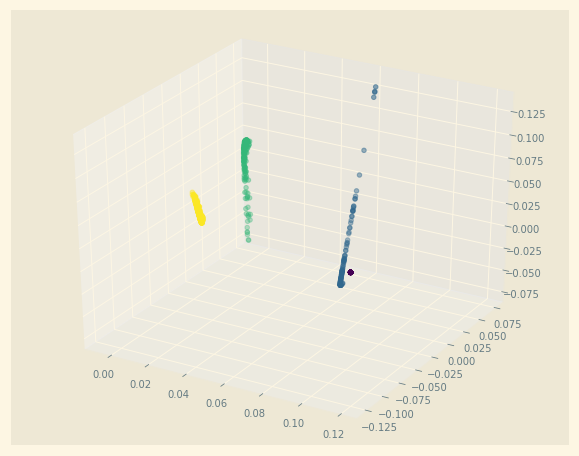

In [90]:
plot_new_space_2d(eig_vals, eig_vecs, n_bonds)

In [93]:
def plot_new_space_2d( eigvals, eigvecs, potentials):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111)  
    c = []
    temp = []
    temp = sorted(temp,reverse=True)
    for i in range(len(eigvals)):
            temp.append(eigvals[i])
    idx1 = diff_map_solver.index(eigvals, temp[1])
    idx2 = diff_map_solver.index(eigvals, temp[2])
    x_plt = []
    y_plt = []
    for i in range(len(eigvecs)): 
        x_plt.append(np.array(eigvecs[i][idx1].real))
        y_plt.append(np.array(eigvecs[i][idx2].real))
        c.append(potentials[i])
    ax.scatter(np.array(x_plt), np.array(y_plt),  c=np.reshape(c,len(c)))
    plt.show()

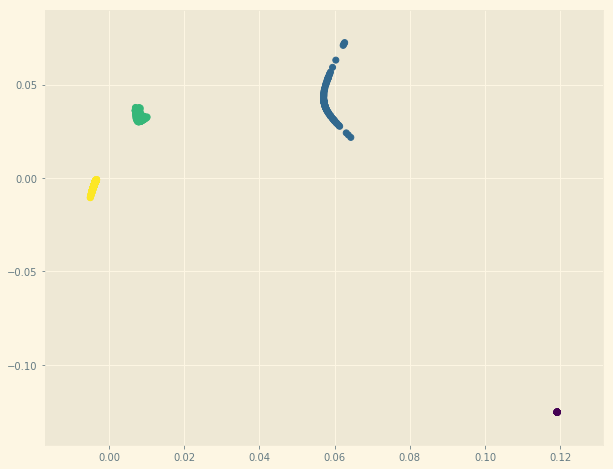

In [94]:
plot_new_space_2d(eig_vals, eig_vecs, n_bonds)

In [132]:
principal_components = get_principle_components(eig_vals, eig_vecs, 3)
with open("eig_space.txt", 'w') as f:
    for i in range(len(coordinates)):
        for principal_component in principal_components:
            f.write(str(eig_vecs[i][principal_component].real) + " ")
        f.write(str"\n")
f.close()

In [142]:
eig_space = []
with open("eig_space.txt", 'r') as f:
    lines = f.readlines()
    for i, line in enumerate(lines):
        data = line.split(" ")
        eig_space.append([])
        for j in range(len(data)-1):
            eig_space[i].append(float(data[j]))
eig_space = np.array(eig_space)

In [144]:
plot_2d(eig_space[:, 1], eig_space[:, 2], color = potential_energy)

NameError: name 'potential_energy' is not defined